### Cell 0: ( Only for Colab ) Install the git **repository**

In [1]:
import sys
import os

# 1. Clone the repository
!git clone -b trajectory_tracking_policy https://github.com/orc-podavini-grisenti/final_assignment

# 2. Point the project_root specifically to the cloned folder
# In Colab, the folder structure will be /content/final_assignment/
project_root = os.path.abspath('/content/final_assignment')

# 3. Add that specific folder to the system path
if project_root not in sys.path:
    sys.path.append(project_root)


# 4. Link the Drive to the colab in order to store the results
from google.colab import drive
drive.mount('/content/drive')

drive_path = "/content/drive/MyDrive/final_assignment/models_saved"

# Crea la cartella se non esiste
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

Cloning into 'final_assignment'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 127 (delta 40), reused 113 (delta 34), pack-reused 0 (from 0)
Receiving objects: 100% (127/127), 627.91 KiB | 9.23 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Mounted at /content/drive


### Cell 1: Imports & Setup

In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt

# --- PATH SETUP ---
# Add the project root to sys.path so we can import envs/planner
# Adjust '..' depending on where this notebook is located relative to root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from envs.unicycle_env import UnicycleEnv
from planner.dubins_planner import DubinsPlanner
from models.trajectory_tracking_network import TTNetwork
from utils.normalization import ObservationNormalizer

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


### Cell 2: Load Training Hyperparameters

In [8]:
# Hyperparameters
MAX_EPISODES = 2000
MAX_STEPS    = 200
LR           = 3e-4
BATCH_SIZE   = 20
GAMMA        = 0.99

SAVE_ON_DRIVE = True

### Cell 3: Intialization

In [4]:
# Init Enviroment and Dubins Planner
env = UnicycleEnv()
planner = DubinsPlanner(curvature_max=1.5, step_size=0.2)


# Initilize the Network.
obs_dim = 3     # Obs dim is 3 (rho, alpha, d_theta)
action_dim = 2  # v, omega

policy = TTNetwork(obs_dim, action_dim).to(device)

# Initializa the otpimizar
optimizer = optim.Adam(policy.parameters(), lr=LR)

# Initializa the input normalizer
obs_normalizer = ObservationNormalizer(max_dist=3.0)

gamma = GAMMA

# Memory buffer for the current episode
log_probs = []
rewards = []

# Memory buffer fot the current batch
loss_history = [] # Store all the batch losses

### Cell 4: Helpers

In [9]:
def get_action(obs):
    """Samples an action and stores its log_probability."""
    # Use the imported normalizer to normaliza the inputs features to give the same relevance
    norm_obs = obs_normalizer.normalize_tt(obs)

    obs_t = torch.FloatTensor(norm_obs).unsqueeze(0).to(device)

    # Call the network to get a action distribution
    mean, std = policy(obs_t)
    dist = Normal(mean, std)

    # Sample a randome action from this distribution
    # NB: randomcicity ensure exploration
    action = dist.sample()

    # Store log_prob for the update step later
    # Sum over action dimensions (v and omega)
    log_prob = dist.log_prob(action).sum(dim=1)
    log_probs.append(log_prob)

    # Return numpy action for the environment
    # Clip to ensure physical validity [-1, 1]
    return np.clip(action.cpu().detach().numpy()[0], -1.0, 1.0)


def store_reward(reward):
    rewards.append(reward)

def store_batch_loss(loss):
    loss_history.append(loss)

### Cell 5: Reinforce Update

In [10]:
# Global storage for the whole batch of trajectories
batch_log_probs = []
batch_returns = []

def calculate_discounted_returns():
    """
    Calculates the 'Return-to-Go' (G_t) for the current episode using causality.

    Mathematical Concept:
    Instead of using the total reward C(tau) for every step, we use G_t:
    G_t = sum_{k=t}^H gamma^(k-t) * r_k

    This reduces variance because actions at time 't' are only reinforced
    based on rewards that happen *after* time 't' (Causality).
    """
    global log_probs, rewards, batch_log_probs, batch_returns

    G_t = 0
    returns = []

    # 1. Calculate Discounted Returns (Backwards)
    # We iterate backwards to easily compute G_t = r_t + gamma * G_{t+1}
    for r in reversed(rewards):
        G_t = r + gamma * G_t
        returns.insert(0, G_t)

    # 2. Store for the Batch Update
    # We do NOT normalize here. We wait to collect all episodes in the batch
    # so we can normalize across the entire dataset (Batch-wise normalization).
    batch_log_probs.extend(log_probs)
    batch_returns.extend(returns)

    # Clear episode memory
    log_probs = []
    rewards = []

def update():
    """
    Performs the Policy Gradient Update using the REINFORCE algorithm.

    Equation Implemented:
    ∇J ≈ (1/N) * Σ_i Σ_t [ ∇ log π(u_t|x_t) * G_t ]

    Where:
    - (1/N): Averaging over the batch size (len(batch_returns))
    - Σ_t: Summing over time steps (done via torch.sum or iterative addition)
    - ∇ log π: Gradients calculated via loss.backward() on log_probs
    - G_t: The normalized returns-to-go
    """
    global batch_log_probs, batch_returns, optimizer

    # Security check: if batch is empty, skip
    if len(batch_returns) == 0:
        return

    # 1. Prepare Data
    # Convert list of returns to a Tensor
    returns_t = torch.tensor(batch_returns).float().to(device)

    # 2. Batch-Wise Normalization (Crucial for Stability)
    # This aligns the returns to be roughly N(0, 1), stabilizing the gradients.
    # It acts as a baseline: actions with G_t > mean are encouraged (+),
    # actions with G_t < mean are discouraged (-).
    if len(returns_t) > 1:
        returns_t = (returns_t - returns_t.mean()) / (returns_t.std() + 1e-9)

    # 3. Calculate Policy Loss
    # We want to maximize J, so we minimize Loss = -J
    # Loss = - Σ ( log_prob * G_t )
    policy_loss = []
    for log_prob, G_t in zip(batch_log_probs, returns_t):
        # Term: - log π(u_t|x_t) * G_t
        policy_loss.append(-log_prob * G_t)

    # Summing all terms corresponds to the Σ_i Σ_t part of the equation
    loss = torch.stack(policy_loss).sum()

    # 4. Backpropagation
    # Dividing by the number of episodes corresponds to the (1/N) term
    # This keeps the gradient magnitude consistent regardless of batch size.
    loss = loss / BATCH_SIZE

    optimizer.zero_grad()
    loss.backward()  # This computes ∇_theta

    # Gradient Clipping (Optional but recommended to prevent exploding gradients)
    torch.nn.utils.clip_grad_norm_(policy.parameters(), 1.0)

    optimizer.step() # Update parameters theta

    # 5. Logging and Cleanup
    store_batch_loss(loss.item())

    # Clear batch memory for the next set of episodes
    batch_log_probs = []
    batch_returns = []

### Cell 6: Training

In [11]:
reward_history = []

print("Starting Training...")

for episode in range(MAX_EPISODES):
    # 1. Reset & Plan
    obs, info = env.reset()
    start_pose = env.state
    goal_pose = env.goal

    # Generate Reference Trajectory
    path = planner.get_path(start_pose, goal_pose)
    if path is None: continue # Skip hard planning cases

    path_idx = 0
    ep_reward = 0

    breack_reason = "Max step reached"      # reason of the episod termination

    # 2. Episode Rollout
    for t in range(MAX_STEPS):
        # A. Determine Target
        target = path[path_idx]

        # B. Observation (Relative to Waypoint)
        # Extract only the first 3 element: [rho, alpha, d_theta]
        # Discard the obstacle part, in the first section are not relevant
        tracking_obs = obs[:3]

        # C. Action
        action = get_action(tracking_obs)

        # D. Step
        # We ignore env reward, we calculate our own
        obs, reward, terminated, truncated, info = env.step(action)

        # E. Reward
        store_reward(reward)
        ep_reward += reward

        # F. Update Waypoint (Pure Pursuit Logic)
        # If close to current waypoint, target the next one
        if tracking_obs[0] < 0.1 and path_idx < len(path) - 1:
            path_idx += 1

        # G. Termination
        dist_to_final = np.linalg.norm(env.state[:2] - goal_pose[:2])
        if dist_to_final < 0.1 and path_idx == len(path) - 1:
            breack_reason = "Goal Reached"
            break
        if info['collision']:
            breack_reason = "Collision"
            break

    # 3. Compute the Returns to Go
    calculate_discounted_returns()

    # 4. If we have collected 'm' trajectories, perform the update
    if (episode + 1) % BATCH_SIZE == 0:
        update() # This effectively divides by m
        print(f"Update performed at episode {episode}")

    reward_history.append(ep_reward)

    if (episode + 1) % BATCH_SIZE == 0:
        avg_r = np.mean(reward_history[-20:])
        print(f"Episode {episode} | Avg Reward: {avg_r:.1f} | Path Len: {len(path)}, Path Step Reached: {path_idx}, {breack_reason}")

print("Training Complete.")

Starting Training...
Update performed at episode 19
Episode 19 | Avg Reward: -1229.3 | Path Len: 15, Path Step Reached: 0, Max step reached
Update performed at episode 39
Episode 39 | Avg Reward: -1227.6 | Path Len: 25, Path Step Reached: 0, Max step reached
Update performed at episode 59
Episode 59 | Avg Reward: -1213.8 | Path Len: 19, Path Step Reached: 6, Max step reached
Update performed at episode 79
Episode 79 | Avg Reward: -1279.8 | Path Len: 30, Path Step Reached: 10, Max step reached
Update performed at episode 99
Episode 99 | Avg Reward: -1166.9 | Path Len: 24, Path Step Reached: 0, Max step reached
Update performed at episode 119
Episode 119 | Avg Reward: -1477.2 | Path Len: 28, Path Step Reached: 0, Max step reached
Update performed at episode 139
Episode 139 | Avg Reward: -1280.3 | Path Len: 13, Path Step Reached: 0, Max step reached
Update performed at episode 159
Episode 159 | Avg Reward: -1236.8 | Path Len: 15, Path Step Reached: 0, Max step reached
Update performed at 

### Cell 7: Visualization & Save
Plot the learning curve to verify convergence.

Results will be saved to: /content/drive/MyDrive/final_assignment/models_saved/experiments/run_20260101_211525


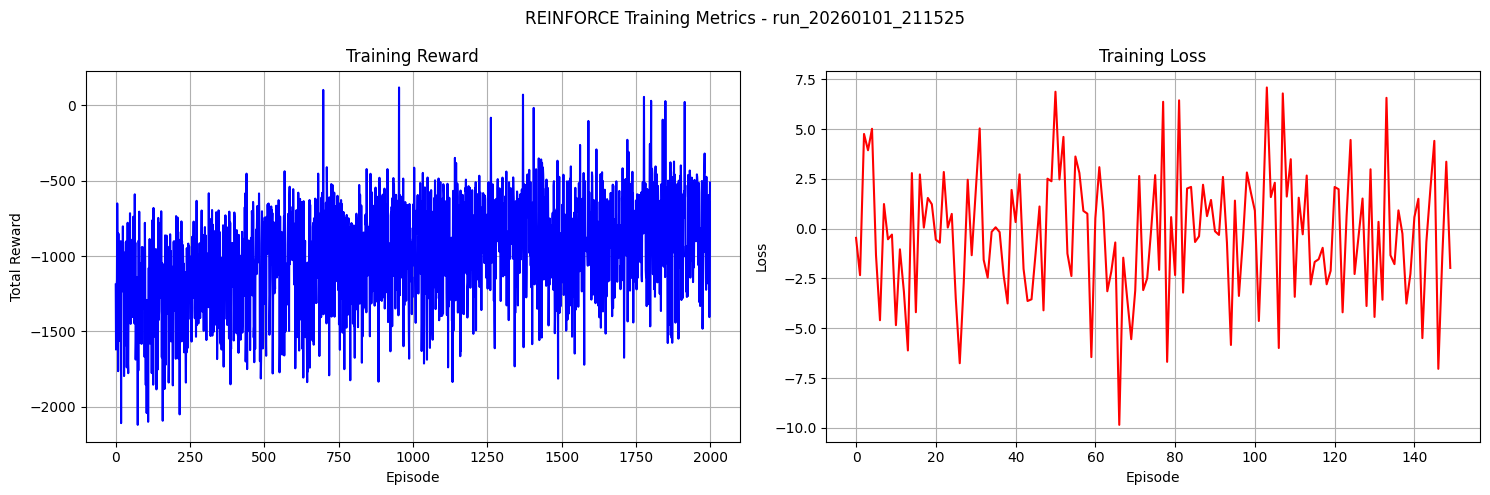

------------------------------
Execution complete.
Directory: /content/drive/MyDrive/final_assignment/models_saved/experiments/run_20260101_211525
Saved: policy_model.pth, training_metrics_plot.png, histories (.npy)
------------------------------


In [12]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# --- 1. SETUP DIRECTORY STRUCTURE ---
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
run_id = f"run_{current_time}"

if SAVE_ON_DRIVE:
    base_output_path = os.path.join(drive_path, "experiments")
else:
    base_output_path = "experiments"

output_dir = os.path.join(base_output_path, run_id)
os.makedirs(output_dir, exist_ok=True)

print(f"Results will be saved to: {output_dir}")

# --- 2. PLOTTING AND SAVING FIGURES ---
# We create a figure with 2 subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Process histories to ensure they are plottable (handle tensors)
clean_rewards = [r.detach().cpu().item() if torch.is_tensor(r) else r for r in reward_history]
clean_losses = [l.detach().cpu().item() if torch.is_tensor(l) else l for l in loss_history]

# Plot 1: Total Reward
ax1.plot(clean_rewards, color='blue')
ax1.set_title("Training Reward")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Total Reward")
ax1.grid(True)

# Plot 2: Training Loss
# Note: Ensure you are appending your loss values to a list named 'loss_history' during training
ax2.plot(clean_losses, color='red')
ax2.set_title("Training Loss")
ax2.set_xlabel("Episode")
ax2.set_ylabel("Loss")
ax2.grid(True)

plt.suptitle(f"REINFORCE Training Metrics - {run_id}")
plt.tight_layout() # Adjust spacing so titles don't overlap

# Save the combined plot
plot_filename = "training_metrics_plot.png"
plt.savefig(os.path.join(output_dir, plot_filename))
plt.show()

# --- 3. SAVING MODEL AND DATA ---
model_filename = "policy_model.pth"
torch.save(policy.state_dict(), os.path.join(output_dir, model_filename))

# Save both histories for future analysis
np.save(os.path.join(output_dir, "reward_history.npy"), np.array(clean_rewards))
np.save(os.path.join(output_dir, "loss_history.npy"), np.array(clean_losses))

print("-" * 30)
print(f"Execution complete.")
print(f"Directory: {output_dir}")
print(f"Saved: {model_filename}, {plot_filename}, histories (.npy)")
print("-" * 30)

### Cell 8: ⚠ Delete the train directory ( only for bed results )

In [ ]:
import shutil

# --- DELETE CURRENT EXPERIMENT DIRECTORY ---
# Ask for confirmation to prevent accidental deletion
confirm = input(f"Do you want to delete the directory '{run_id}'? (y/n): ")

if confirm.lower() == 'y':
    try:
        # shutil.rmtree deletes a directory and all its contents
        shutil.rmtree(output_dir)
        print(f"Successfully deleted: {output_dir}")
    except OSError as e:
        print(f"Error: {e.strerror}. Could not delete the directory.")
else:
    print("Deletion cancelled. Experiment results preserved.")

Do you want to delete the directory 'run_20260101_175404'? (y/n): y
Successfully deleted: /content/drive/MyDrive/final_assignment/models_saved/experiments/run_20260101_175404
